数据筛选，筛选沪深300

## 运行环境

In [1]:
#导入包
import numpy as np
import pandas as pd
import datetime
import warnings
warnings.filterwarnings('ignore')

## 数据筛选

In [2]:
#hs300名单 2022.1.1之前
hs300=pd.read_csv(r'../hs300_2005-2022/hs300_monthly.csv',dtype = object)
hs300=hs300.drop('Unnamed: 0',axis=1)
hs300=hs300.rename(columns={'stock': 'code'})

In [3]:
hs300['month']=hs300['month'].astype(int)
type(hs300['month'][0])

numpy.int32

## 定义参数类

In [4]:
## 定义参数类
# -- define a class including all parameters
class Para():
    method = 'LR' 
    month_in_sample = range(82, 153 + 1)  # -- return 82~153 72 months
    month_test = range(154, 293 + 1)  # -- return 154~293 140 months

    percent_select = [0.3, 0.3]  # -- 30% positive samples, 30% negative samples
    percent_cv = 0.1  # -- percentage of cross validation samples 交叉验证的样本比例
    path_data = '../data/csv_01/'
    path_results = './results/'
    seed = 42  # -- random seed
    n_stock = 5166
para = Para()

## Time of Rolling_Window

In [5]:
train_data_min_months = 72  # 每次模型训练所用数据最少不低于
train_data_max_months = 108  # 每次模型训练所用数据最大不超过
train_update_months = 6  # 设置更新周期
start_date = 82  # 第一次滚动训练开始日期
end_date = start_date + train_data_min_months  # 第一次滚动训练结束日期

## 样本内训练

### 样本内数据集

In [6]:
## 生成样本内数据集
# -- generate in-sample data
period_train = range(start_date, end_date + 1)
a1 = pd.DataFrame([np.nan] * np.zeros((para.n_stock, period_train[-1] )))
for i_month in period_train:
    # -- load csv
    file_name = para.path_data + str(i_month) + '.csv'
    data_curr_month = pd.read_csv(file_name, header=0)  # 设置表头
    para.n_stock = data_curr_month.shape[0]
    # -- remove nan
    data_curr_month = data_curr_month.dropna(axis=0)
    # return data merge
    a1.iloc[data_curr_month.index, i_month-1] = data_curr_month['return'][data_curr_month.index]
    # -- merge
    if i_month == period_train[0]:  # -- first month
        data_in_sample_all = data_curr_month
    else:
        data_in_sample_all = pd.concat((data_in_sample_all, data_curr_month), axis=0)
    data_in_sample_all['code'] = data_in_sample_all['stock'].str.replace('[^\d]', '', regex=True)
data_in_sample_all

,month,stock,status,return,EP,EPcut,BP,SP,NCFP,OCFP,...,CON_GPE,CON_NP,CON_ROE,CON_BP_REL,CON_EP_REL,CON_EPS_REL,CON_GPE_REL,CON_NP_REL,CON_ROE_REL,code
0,82,000001.SZ,1,-0.032765,-0.273931,-0.277662,-0.324310,0.236972,-2.766430,0.024694,...,-0.821388,-1.072420,-1.537050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,000001
1,82,000002.SZ,1,-0.080166,-0.315341,0.127276,-0.151405,-0.125512,2.012020,-1.662190,...,1.155480,3.214830,0.597497,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,000002
3,82,000004.SZ,1,0.033170,-0.105983,0.152291,-1.228440,-0.724589,0.221517,0.139698,...,0.112900,0.573688,0.208719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,000004
4,82,000005.SZ,1,0.020597,-0.430779,-0.350940,0.350246,-0.798821,-0.043290,-0.058098,...,-0.016410,-0.083384,-0.030337,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,000005
5,82,000006.SZ,1,0.053351,-2.497890,-3.042320,1.141110,1.691610,0.178978,1.058570,...,0.024729,0.125657,0.045716,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,000006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2760,154,601988.SH,1,-0.054630,-0.749797,-0.747865,0.266036,-0.078502,1.198540,0.615647,...,-1.053470,-2.353540,-0.633723,-0.607834,-0.517425,-0.488757,-0.565068,-0.154173,-0.210162,601988
2761,154,601989.SH,1,-0.025670,-1.483120,-1.534630,-0.473187,-0.600038,1.188960,-0.970114,...,-0.151055,-0.654391,-1.092370,-1.450320,-1.504000,-1.214060,-1.466940,-1.357990,-1.041310,601989
2762,154,601991.SH,1,-0.006187,-0.953193,-0.776578,-0.112703,0.906936,-0.692536,1.066650,...,-0.672471,-0.331530,-1.014620,0.805792,-0.312296,-1.053110,-0.381491,-1.418590,-1.419910,601991
2765,154,601998.SH,1,-0.022967,-0.002193,0.046003,-0.050428,-0.025722,1.200430,0.830662,...,0.167583,-0.080914,-0.005012,0.231311,0.444478,0.517950,0.489780,0.240163,0.447021,601998


In [7]:
# 筛选出名单内的hs300
data_in_sample=pd.merge(hs300,data_in_sample_all,on=['code','month'],how='inner')
data_in_sample

,month_details,code,stock_name,month,stock,status,return,EP,EPcut,BP,...,CON_EPS,CON_GPE,CON_NP,CON_ROE,CON_BP_REL,CON_EP_REL,CON_EPS_REL,CON_GPE_REL,CON_NP_REL,CON_ROE_REL
0,2005-04,600177,雅戈尔,85,600177.SH,1,-0.070827,1.265230,1.002070,-0.479064,...,-0.263749,-0.923119,3.992780,0.826338,0.754544,-0.812528,1.962790,-0.797452,2.020360,-1.991710
1,2005-04,000709,河钢股份,85,000709.SZ,1,0.063798,0.933537,0.882632,1.037910,...,-1.003780,-2.297900,-0.292271,-1.056970,-1.000200,-1.149510,-0.714925,-1.930510,-1.013790,-0.410213
2,2005-04,600170,上海建工,85,600170.SH,1,0.120855,0.127632,0.417247,0.645900,...,-0.255405,0.017635,-0.679392,-0.247926,0.093515,0.215508,-0.063171,0.091260,-0.048462,0.142280
3,2005-04,600188,兖州煤业,85,600188.SH,1,-0.074323,-0.709447,-0.795202,0.302718,...,0.492043,-1.200720,1.100130,-0.880423,2.365200,1.514660,3.005990,-0.025878,2.442340,-1.140040
4,2005-04,600221,海航控股,85,600221.SH,1,0.022659,0.388387,-1.973420,0.469793,...,0.127192,-0.008782,0.338339,0.123468,-0.046571,-0.107324,0.031460,-0.045448,0.024134,-0.070856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19900,2011-01,601899,紫金矿业,154,601899.SH,1,0.089506,0.712551,0.803344,-0.181255,...,-1.468270,-0.260766,-0.649200,0.380018,1.541110,1.149270,0.127088,0.472869,0.022959,0.117971
19901,2011-01,601939,建设银行,154,601939.SH,1,-0.051492,-0.890930,-0.897731,-0.396195,...,-1.613180,-0.712414,-2.782560,-0.110547,-0.652911,-0.436047,-0.342374,-0.242703,-0.286842,-0.012889
19902,2011-01,601988,中国银行,154,601988.SH,1,-0.054630,-0.749797,-0.747865,0.266036,...,-1.936540,-1.053470,-2.353540,-0.633723,-0.607834,-0.517425,-0.488757,-0.565068,-0.154173,-0.210162
19903,2011-01,601989,中国重工,154,601989.SH,1,-0.025670,-1.483120,-1.534630,-0.473187,...,-1.827710,-0.151055,-0.654391,-1.092370,-1.450320,-1.504000,-1.214060,-1.466940,-1.357990,-1.041310


In [8]:
# 样本内数据集
# -- generate in-sample data
X_in_sample = data_in_sample.loc[:, 'EP':'bias']  # 提取数据
X_in_sample

,EP,EPcut,BP,SP,NCFP,OCFP,DP,G/PE,Sales_G_q,Profit_G_q,...,rating_average,rating_change,rating_targetprice,holder_avgpctchange,macd,dea,dif,rsi,psy,bias
0,1.265230,1.002070,-0.479064,-0.437100,-0.037023,1.173520,1.179950,2.056410,2.249070,0.870076,...,-0.826200,0.180845,4.325220,-0.077879,-0.940332,-1.644330,-1.577170,-0.174766,0.259235,-0.858726
1,0.933537,0.882632,1.037910,1.187110,2.003970,1.747070,3.134570,0.649900,-0.103706,-0.071435,...,0.079409,0.426142,-0.218470,0.305885,0.475959,0.115052,0.301571,0.971640,2.347480,0.300705
2,0.127632,0.417247,0.645900,1.438000,-1.049520,0.650388,0.547125,-0.580610,0.286971,-0.510763,...,0.567778,-0.048600,0.129120,0.083134,-0.393560,-0.226285,-0.293435,0.064153,0.038483,-0.042209
3,-0.709447,-0.795202,0.302718,-0.508849,0.392517,-0.165509,-0.742424,0.743625,-0.653277,-0.351898,...,0.455468,-1.386170,-0.429177,-1.453670,-0.298054,1.424120,0.937088,0.638203,1.003870,1.345260
4,0.388387,-1.973420,0.469793,3.267270,0.512391,2.291920,-0.604894,-1.097520,-0.137634,-0.787297,...,0.939212,0.411431,-0.064302,-0.408494,-0.114832,-0.049491,-0.087244,0.881168,-0.061439,0.142990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19900,0.712551,0.803344,-0.181255,-0.706954,0.004760,0.984349,1.339690,-0.310205,-0.880150,-0.742481,...,0.870294,-0.060686,1.486890,0.759178,0.258266,-1.841170,-1.735470,0.237903,0.731158,0.384763
19901,-0.890930,-0.897731,-0.396195,-0.258380,0.208452,0.575056,0.092669,-0.706414,-0.845923,-0.590683,...,0.415533,-0.044858,-0.639200,0.602524,0.190567,-0.747902,-0.621458,-0.236143,-0.931439,-0.100092
19902,-0.749797,-0.747865,0.266036,-0.078502,1.198540,0.615647,0.180609,-0.744734,-0.762882,-0.551015,...,1.323690,3.853010,-0.097722,0.410499,0.079468,-0.652300,-0.570150,-0.215490,0.298843,0.141453
19903,-1.483120,-1.534630,-0.473187,-0.600038,1.188960,-0.970114,-0.871543,-0.962289,-1.283050,-0.826014,...,0.331612,-0.184501,-2.306590,1.595800,0.543845,-1.527980,-1.342150,-1.268370,-0.600144,-1.626710


In [9]:
# -- regression
if para.method in ['LR']:
    y_in_sample = data_in_sample.loc[:, 'return']
y_in_sample

0       -0.070827
1        0.063798
2        0.120855
3       -0.074323
4        0.022659
           ...   
19900    0.089506
19901   -0.051492
19902   -0.054630
19903   -0.025670
19904   -0.022967
Name: return, Length: 19905, dtype: float64

### 划分训练集与验证集

In [10]:
## 划分训练集和验证集
# -- generate train and cv data
from sklearn.model_selection import train_test_split

# 随机拆分数据为train set训练集和test set测试集
# X:要划分的样本特征集（输入的信息）
# y:需要划分的样本结果（输出结果）
# test_size:样本占比，测试集在总数中的百分比（小数表示）
# random_state:随机数种子，对于模型分割，必须用同一随机数种子，保证每次随机分割后数据集不变。
if para.percent_cv > 0:
    X_train, X_cv, y_train, y_cv = train_test_split(X_in_sample, y_in_sample, test_size=para.percent_cv,
                                                        random_state=para.seed)
else:
    X_train, y_train = X_in_sample.copy(), y_in_sample.copy()

### model

In [11]:
# 有监督，连续型数据
# -- linear regression
from sklearn import linear_model
from sklearn.decomposition import PCA
if para.method in ['LR']:
    model = linear_model.LinearRegression(fit_intercept=True)  # 计算偏置（截距）
    # -- regression
    model.fit(X_train, y_train)
    y_score_train = model.predict(X_train)
    if para.percent_cv > 0:
        y_score_cv = model.predict(X_cv)
y_score_train

array([ 0.00624125, -0.00985954, -0.02648852, ...,  0.00445838,
       -0.01604534, -0.00593321])

### 回归系数

In [12]:
#输出回归系数
factor_weights = pd.DataFrame({'Regression_coefficient': model.coef_})
factor_weights.sort_values(by='Regression_coefficient', ascending=False)[0:10]

,Regression_coefficient
54,0.025292
41,0.012517
38,0.007644
30,0.006903
48,0.006742
9,0.005576
12,0.005090
56,0.004402
45,0.004399
3,0.003825


### 因子信息系数

In [13]:
columns = ['code','month']
factors_columns = data_in_sample.columns[7:-12]
for i in factors_columns:
    columns.append(i)
X_in_sample_ic = data_in_sample.loc[:, columns]  # 提取数据
y_in_sample_ic = data_in_sample[['code','month','return']]

In [14]:
X_in_sample_ic

,code,month,EP,EPcut,BP,SP,NCFP,OCFP,DP,G/PE,...,rating_average,rating_change,rating_targetprice,holder_avgpctchange,macd,dea,dif,rsi,psy,bias
0,600177,85,1.265230,1.002070,-0.479064,-0.437100,-0.037023,1.173520,1.179950,2.056410,...,-0.826200,0.180845,4.325220,-0.077879,-0.940332,-1.644330,-1.577170,-0.174766,0.259235,-0.858726
1,000709,85,0.933537,0.882632,1.037910,1.187110,2.003970,1.747070,3.134570,0.649900,...,0.079409,0.426142,-0.218470,0.305885,0.475959,0.115052,0.301571,0.971640,2.347480,0.300705
2,600170,85,0.127632,0.417247,0.645900,1.438000,-1.049520,0.650388,0.547125,-0.580610,...,0.567778,-0.048600,0.129120,0.083134,-0.393560,-0.226285,-0.293435,0.064153,0.038483,-0.042209
3,600188,85,-0.709447,-0.795202,0.302718,-0.508849,0.392517,-0.165509,-0.742424,0.743625,...,0.455468,-1.386170,-0.429177,-1.453670,-0.298054,1.424120,0.937088,0.638203,1.003870,1.345260
4,600221,85,0.388387,-1.973420,0.469793,3.267270,0.512391,2.291920,-0.604894,-1.097520,...,0.939212,0.411431,-0.064302,-0.408494,-0.114832,-0.049491,-0.087244,0.881168,-0.061439,0.142990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19900,601899,154,0.712551,0.803344,-0.181255,-0.706954,0.004760,0.984349,1.339690,-0.310205,...,0.870294,-0.060686,1.486890,0.759178,0.258266,-1.841170,-1.735470,0.237903,0.731158,0.384763
19901,601939,154,-0.890930,-0.897731,-0.396195,-0.258380,0.208452,0.575056,0.092669,-0.706414,...,0.415533,-0.044858,-0.639200,0.602524,0.190567,-0.747902,-0.621458,-0.236143,-0.931439,-0.100092
19902,601988,154,-0.749797,-0.747865,0.266036,-0.078502,1.198540,0.615647,0.180609,-0.744734,...,1.323690,3.853010,-0.097722,0.410499,0.079468,-0.652300,-0.570150,-0.215490,0.298843,0.141453
19903,601989,154,-1.483120,-1.534630,-0.473187,-0.600038,1.188960,-0.970114,-0.871543,-0.962289,...,0.331612,-0.184501,-2.306590,1.595800,0.543845,-1.527980,-1.342150,-1.268370,-0.600144,-1.626710


In [15]:
# 提取code和month列
code_col = X_in_sample_ic['code']
month_col = X_in_sample_ic['month']

# 获取下一期的收益率数据
next_month = y_in_sample_ic['month'] + 1
y_in_sample_next = y_in_sample_ic['code']
y_in_sample_next=pd.DataFrame(y_in_sample_next)
y_in_sample_next['month'] = next_month
y_in_sample_next = y_in_sample_ic.merge(y_in_sample_next, on=['code', 'month'])
y_in_sample_next['month'] = y_in_sample_next['month']-1
# 合并X和y数据
data_merged = y_in_sample_next.merge(X_in_sample_ic, on=['code', 'month'])

ic_values = {}  # 存储每个因子的IC值

for column in data_merged.columns[3:]:  # 从第四列开始计算IC，假设第一列是code，第二列是month，第三列是下一期的收益率
    factor_values = data_merged[column]
    y_values = data_merged.iloc[:, 2]  # 下一期的收益率值
    correlation = np.corrcoef(factor_values, y_values)[0, 1]
    ic_values[column] = correlation

# 创建包含因子和IC值的DataFrame
information_coefficient = pd.DataFrame(list(ic_values.items()), columns=['Factor', 'IC'])

# 打印结果
information_coefficient

,Factor,IC
0,EP,0.041070
1,EPcut,0.035758
2,BP,0.005659
3,SP,0.025915
4,NCFP,0.010921
...,...,...
65,dea,0.000253
66,dif,-0.003464
67,rsi,-0.004367
68,psy,0.005253


In [16]:
information_coefficient_top = information_coefficient.sort_values(by='IC', ascending=False)
information_coefficient_top[:10]

,Factor,IC
0,EP,0.041070
1,EPcut,0.035758
13,ROE_ttm,0.033079
9,Profit_G_q,0.032806
12,ROE_q,0.030287
5,OCFP,0.029854
11,ROE_G_q,0.026321
3,SP,0.025915
6,DP,0.021253
15,ROA_ttm,0.020545


### 因子纯度
共同度（Communality）：
共同度是用于衡量每个变量与所有因子之间的相关性或共享的方差比例。共同度的范围在0到1之间，值越接近1表示变量与因子之间的相关性越高。通过计算每个变量与所有因子之间的相关性的平方和，可以得到共同度的估计值。

In [17]:
# 假设X_in_sample为观测数据
# 计算相关矩阵
corr_matrix = X_in_sample.corr()
# 计算共同度
communality = np.sum(corr_matrix**2, axis=1)
communality = pd.DataFrame({'communality':communality})
# 打印结果
print("Communality for each factor:",communality)
communality.sort_values(by='communality', ascending=False)

Communality for each factor:        communality
EP        4.906456
EPcut     4.881780
BP        3.638523
SP        3.885952
NCFP      1.336426
...            ...
dea       3.190821
dif       3.766795
rsi       2.467107
psy       2.136026
bias      5.310213

[70 rows x 1 columns]


,communality
exp_wgt_return_12m,8.960146
exp_wgt_return_6m,8.607100
wgt_return_6m,7.420549
wgt_return_3m,7.359838
exp_wgt_return_3m,7.242089
...,...
operationcashflowratio_q,1.611294
OCF_G_q,1.484830
NCFP,1.336426
ln_capital,1.225185


### 因子稳定性
因子稳定性用于评估因子分析结果在不同样本或数据集上的一致性。一种常用的方法是使用因子载荷的稳定性，即在不同数据集上计算因子载荷的相关性。相关性越高，表示因子在不同数据集上的稳定性越高。

In [18]:
# 计算相关矩阵
corr_matrix_train = X_train.corr()
# 假设X_out_sample是另一个数据集的DataFrame对象
# 计算相关矩阵
corr_matrix_cv = X_cv.corr()
# 计算因子载荷的相关性
factor_stability = np.corrcoef(corr_matrix_train.values.flatten(), corr_matrix_cv.values.flatten())[0, 1]
# 打印结果
print("Factor stability:", factor_stability)

Factor stability: 0.9943156003828295


In [19]:
# 计算相关矩阵
corr_matrix_in_sample = X_in_sample.corr()
# 初始化稳定性结果列表
factor_stability = []
# 遍历每个因子
for i in range(len(corr_matrix_in_sample.columns)):
    # 取出当前因子的名称
    factor_name = corr_matrix_in_sample.columns[i]
    # 取出当前因子的相关系数
    factor_corr = corr_matrix_in_sample.iloc[i, :]
    # 计算因子与其他因子的相关系数的均值
    factor_stability.append((factor_name, np.mean(factor_corr)))
# 创建包含因子名称和稳定性的DataFrame
factor_stability_df = pd.DataFrame(factor_stability, columns=['Factor', 'Stability'])
# 打印结果
print("Factor stability for each factor:",factor_stability_df)
factor_stability_df

Factor stability for each factor:    Factor  Stability
0      EP   0.147034
1   EPcut   0.141620
2      BP   0.090591
3      SP   0.028671
4    NCFP   0.033649
..    ...        ...
65    dea   0.101313
66    dif   0.116889
67    rsi   0.089049
68    psy   0.078204
69   bias   0.140585

[70 rows x 2 columns]


,Factor,Stability
0,EP,0.147034
1,EPcut,0.141620
2,BP,0.090591
3,SP,0.028671
4,NCFP,0.033649
...,...,...
65,dea,0.101313
66,dif,0.116889
67,rsi,0.089049
68,psy,0.078204


### 因子合成

**PCA提取的最佳因子数量是16**

Explained Variance Ratio: [0.14164666 0.11219648 0.07624028 0.06104582 0.05728871 0.03740417
 0.0349872  0.03212388 0.03003303 0.02875204 0.02605989 0.02202506
 0.01989731 0.01938559 0.01811451 0.01680931]


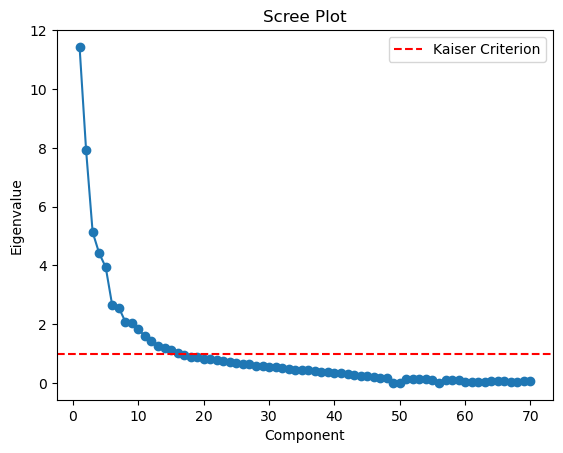

Number of components based on Kaiser Criterion: 16


In [20]:
# PCA 提取的最佳因子数量是16
from sklearn.decomposition import PCA
## 方差解释
from sklearn.decomposition import FactorAnalysis
### 观测数据
pca_1 = PCA(n_components=16)
pca_1.fit(X_in_sample)
### 获取解释方差比例
explained_variance_ratio = pca_1.explained_variance_ratio_
### 输出解释方差比例
print("Explained Variance Ratio:",explained_variance_ratio)

## Kaiser准则（Kaiser Criterion）和Scree图：可以通过绘制特征值与因子数量的折线图来观察拐点或"肘部"
import matplotlib.pyplot as plt
# eigenvalues是特征值的数组
X_in_sample_array = X_in_sample.values
# 计算相关矩阵
corr_matrix = np.corrcoef(X_in_sample_array, rowvar=False)
# 计算特征值
eigenvalues = np.linalg.eigvals(corr_matrix)
# 计算Kaiser准则
kaiser_threshold = 1
# 确定保留的主成分数量
num_components_kaiser = np.sum(eigenvalues > kaiser_threshold)
# 绘制Scree图
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'o-')
plt.xlabel('Component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.axhline(y=kaiser_threshold, color='r', linestyle='--', label='Kaiser Criterion')
plt.legend()
plt.show()
# 打印结果
print("Number of components based on Kaiser Criterion:", num_components_kaiser)

#### 纯度

In [21]:
# 假设factor_loadings因子载荷矩阵
pca_2 = PCA(n_components=16)  # 设置主成分数量为16
factor_loadings_2 = pca_2.fit_transform(X2)
# 计算总因子数和原始变量数
n_factors = factor_loadings_2.shape[1]
n_variables = factor_loadings_2.shape[0]
# 初始化纯度列表
purity_list = []
# 遍历每个因子
for k in range(n_factors):
    # 计算第k个因子的纯度
    purity = np.sum(factor_loadings_2[:, k] ** 2)
    purity_list.append(purity)
# 创建包含因子纯度的DataFrame
purity_df = pd.DataFrame({'Factor': range(1, n_factors+1), 'Purity': purity_list})
# 打印结果
print("Factor purity:")
print(purity_df)

NameError: name 'X2' is not defined

纯度的含义是衡量因子与原始变量之间的相关性的累积程度。如果一个因子与一个或多个相关的原始变量具有高载荷值，那么它的纯度会比较高。反之，如果因子与原始变量之间的相关性较低，那么它的纯度会较低。

通过计算每个因子的纯度，您可以了解每个因子对原始变量的解释能力。较高的纯度值表示该因子能够很好地解释相关的原始变量，而较低的纯度值则表示该因子的解释能力较弱。

纯度的计算可以帮助您进行因子选择和解释结果。通常情况下，您会选择具有较高纯度的因子，因为它们能够更好地解释原始变量的方差。同时，较低纯度的因子可能会对结果产生较小的影响，或者可能需要进一步解释。

#### 稳定性

In [ ]:
# 定义重复次数
num_repetitions = 10
# 初始化稳定性结果字典
factor_stability = {}
# 遍历每个因子
for factor_name in X_train.columns:
    # 初始化相关系数列表
    corr_list = []
    # 进行重复次数的循环
    for i in range(num_repetitions):
        # 将数据集划分为两个子样本
        X1, X2 = train_test_split(X_train, test_size=0.5)
        # 在每个子样本上进行主成分分析
        pca1 = PCA(n_components=16)  # 设置主成分数量为16
        pca2 = PCA(n_components=16)
        factor_loadings1 = pca1.fit_transform(X1)
        factor_loadings2 = pca2.fit_transform(X2)
        # 计算因子载荷矩阵之间的相关系数
        corr = np.corrcoef(factor_loadings1.T, factor_loadings2.T)[0, 1]
        # 添加相关系数到列表中
        corr_list.append(corr)
    # 计算相关系数的平均值，作为稳定性值
    factor_stability[factor_name] = np.mean(corr_list)
# 创建包含因子名称和稳定性的DataFrame
factor_stability_df = pd.DataFrame.from_dict(factor_stability, orient='index', columns=['Stability'])
# 打印结果
print("Factor stability for each factor:",factor_stability_df)
factor_stability_df

In [ ]:
factor_stability_df.sort_values(by='Stability', ascending=False)

计算得到的稳定性较低，即稳定性值接近0，表示因子在不同样本中的表现差异较大。这可能表明因子在不同样本之间的结构不一致，其影响力和解释能力可能不稳定，不可靠。

## 确定因子权重

### 基于回归系数

In [22]:
# 获取回归系数
coefficients = model.coef_
# 计算因子权重
factor_weights_1 = abs(coefficients) / sum(abs(coefficients))
selected_stocks_all = pd.DataFrame()
# 整合划分月份数据--并逐月打分
for i in period_train:
    data_for_score= data_in_sample[data_in_sample['month']==i]
    X_for_score= data_for_score.loc[:, 'EP':'bias']  # 提取数据
    # 计算每只股票的打分
    scores = X_for_score.dot(factor_weights_1)
    n = 30
    selected_stocks = scores.nlargest(n)
    # 添加month和stock列
    selected_stocks = pd.DataFrame({'month': i, 'code': data_for_score.loc[selected_stocks.index, 'code'], 'score': selected_stocks.values})
    # 合并
    selected_stocks_all = pd.concat([selected_stocks_all, selected_stocks], ignore_index=True)
# 统计出现的次数
stock_counts_coef = pd.DataFrame({'frequence_counts':selected_stocks_all['code'].value_counts()})
stock_counts_coef[:20]

,frequence_counts
code,
600271,42
600006,28
600601,28
000538,27
600588,26
600519,25
600809,24
600596,24
600098,23


### 基于信息系数
计算每个因子与目标变量之间的信息系数（IC），并使用IC作为权重。较高的IC表示该因子在预测目标变量方面更有效，因此应该分配较高的权重。

In [23]:
# 基于信息系数大小的权重分配
def assign_weight_by_coefficient(information_coefficient):
    # 计算绝对值大于0.02的IC值的总和
    ic_sum = abs(information_coefficient.loc[information_coefficient['IC'] > 0.02, 'IC']).sum()
    # 分配权重
    information_coefficient.loc[information_coefficient['IC'] > 0.02, 'Weight'] = 0.5 * (abs(information_coefficient['IC']) / ic_sum)
    information_coefficient.loc[information_coefficient['IC'] <= 0.02, 'Weight'] = 0.5 * ((0.02 - abs(information_coefficient['IC'])) / (1 - ic_sum))
    return information_coefficient

weighted_factors_coefficient = assign_weight_by_coefficient(information_coefficient)
factor_weights_2 = np.array(weighted_factors_coefficient['Weight'])
selected_stocks_all = pd.DataFrame()
# 整合划分月份数据--并逐月打分
for i in period_train:
    data_for_score= data_in_sample[data_in_sample['month']==i]
    X_for_score= data_for_score.loc[:, 'EP':'bias']  # 提取数据
    # 计算每只股票的打分
    scores = X_for_score.dot(factor_weights_2)
    n = 30
    selected_stocks = scores.nlargest(n)
    # 添加month和stock列
    selected_stocks = pd.DataFrame({'month': i, 'code': data_for_score.loc[selected_stocks.index, 'code'], 'score': selected_stocks.values})
    # 合并
    selected_stocks_all = pd.concat([selected_stocks_all, selected_stocks], ignore_index=True)
# 统计出现的次数
stock_counts_ic = pd.DataFrame({'frequence_counts':selected_stocks_all['code'].value_counts()})
stock_counts_ic[:20]

,frequence_counts
code,
000900,38
000912,35
000933,34
600066,32
600886,28
600269,28
600418,27
000612,27
600033,27


### 基于协方差矩阵
计算因子之间的协方差矩阵，并使用协方差矩阵的逆作为权重。这种方法将更高的权重分配给具有较低相关性的因子。

In [24]:
covariance_matrix = X_in_sample.cov()
# 计算协方差矩阵的逆
inverse_covariance_matrix = np.linalg.inv(covariance_matrix)
# 计算每个因子的相关性得分
correlation_scores = np.sum(inverse_covariance_matrix, axis=0)
# 将相关性得分归一化为权重
weights = correlation_scores / np.sum(correlation_scores)
# 创建权重分配的DataFrame，并按权重降序排序
factor_weights = pd.DataFrame({'Factor': X_in_sample.columns, 'Weight': weights})
factor_weights_sorted = factor_weights.sort_values(by='Weight', ascending=False)
factor_weights_3 = np.array(factor_weights_sorted['Weight'])
selected_stocks_all = pd.DataFrame()
# 整合划分月份数据--并逐月打分
for i in period_train:
    data_for_score= data_in_sample[data_in_sample['month']==i]
    X_for_score= data_for_score.loc[:, 'EP':'bias']  # 提取数据
    # 计算每只股票的打分
    scores = X_for_score.dot(factor_weights_3)
    n = 30
    selected_stocks = scores.nlargest(n)
    # 添加month和stock列
    selected_stocks = pd.DataFrame({'month': i, 'code': data_for_score.loc[selected_stocks.index, 'code'], 'score': selected_stocks.values})
    # 合并
    selected_stocks_all = pd.concat([selected_stocks_all, selected_stocks], ignore_index=True)
# 统计出现的次数
stock_counts_cor = pd.DataFrame({'frequence_counts':selected_stocks_all['code'].value_counts()})
stock_counts_cor[:20]

,frequence_counts
code,
000900,52
000630,32
600418,29
600033,29
600066,29
600690,28
000528,27
000778,27
000680,26


## 样本外预测

In [25]:
test_date_start = end_date + 1
test_date_end = end_date + 6
period_test = range(test_date_start, test_date_end + 1)

In [26]:
combined_y_pred_return = pd.DataFrame()
combined_y_curr_return = pd.DataFrame()
for i_month in period_test:
    # -- load
    file_name = para.path_data + str(i_month) + '.csv'
    data_curr_month = pd.read_csv(file_name, header=0)
    # -- remove nan
    data_curr_month = data_curr_month.dropna(axis=0)
    # --hs300
    data_curr_month['code'] = data_curr_month['stock'].str.replace('[^\d]', '', regex=True)
    data_curr_month = pd.merge(hs300,data_curr_month,on=['code','month'],how='inner')
    # -- generate X
    X_curr_month = data_curr_month.loc[:, 'EP':'bias']
    # -- pca
    pca = PCA(n_components=16)
    X_curr_month = pca.fit_transform(X_curr_month)
    # -- pca_train
    X_train_pca = pca.fit_transform(X_train)
    model_pca = linear_model.LinearRegression(fit_intercept=True)
    model_pca.fit(X_train_pca, y_train)
    # -- linear regression
    if para.method in ['LR']:
        y_score_curr_month = model_pca.predict(X_curr_month)
    y_pred_return = pd.DataFrame({'month':data_curr_month['month'],'code':data_curr_month['code'],'pred_return':y_score_curr_month})
    combined_y_pred_return = pd.concat([combined_y_pred_return, y_pred_return], axis=0)
    # -- curr_return
    y_curr_return = pd.DataFrame({'month':data_curr_month['month'],'code':data_curr_month['code'],'curr_return':data_curr_month['return']})
    combined_y_curr_return = pd.concat([combined_y_curr_return, y_curr_return], axis=0)
combined_y_pred_return = pd.pivot_table(combined_y_pred_return, values='pred_return', index='code', columns=['month'])
combined_y_curr_return = pd.pivot_table(combined_y_curr_return, values='curr_return', index='code', columns=['month'])
combined_y_pred_return

month,155,156,157,158,159,160
code,,,,,,
000001,0.011080,0.004372,-0.017158,-0.006821,0.005698,-0.006617
000002,0.011379,-0.009458,0.016949,0.005783,0.007371,0.010472
000009,-0.004334,0.015485,-0.011388,0.000216,-0.017096,-0.012577
000012,0.006696,0.011238,0.009739,0.002615,0.023904,-0.002299
000021,0.005370,0.018707,-0.011448,-0.009148,0.021441,0.013960
...,...,...,...,...,...,...
601939,0.017031,0.013054,-0.000148,0.009441,-0.004467,0.011341
601958,-0.001930,-0.007049,0.001840,0.015465,-0.019162,0.012954
601988,0.024762,0.020174,0.015824,0.008332,0.011694,0.019035


### 模型简易评价

In [27]:
if para.method in ['LR']:
    y_train.index = range(len(y_train))
    y_score_train = pd.Series(y_score_train)
    print('training set, ic = %.2f' % y_train.corr(y_score_train))
    if para.percent_cv > 0:
        y_cv.index = range(len(y_cv))
        y_score_cv = pd.Series(y_score_cv)
        print('cv set, ic = %.2f' % y_cv.corr(y_score_cv))
    for i_month in period_test:
        y_true_curr_month = pd.Series(combined_y_curr_return[i_month])
        y_score_curr_month = pd.Series(combined_y_pred_return[i_month])
        print('testing set, month %d, ic = %.2f' % (i_month, y_true_curr_month.corr(y_score_curr_month)))

training set, ic = 0.13
cv set, ic = 0.08
testing set, month 155, ic = 0.04
testing set, month 156, ic = 0.15
testing set, month 157, ic = -0.08
testing set, month 158, ic = -0.14
testing set, month 159, ic = -0.04
testing set, month 160, ic = 0.01


## 优化问题求解

### 优化器_1

In [28]:
from scipy.optimize import minimize
import cvxpy as cp

def calculate_portfolio_weights(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    weights = cp.Variable(num_assets)
    # 定义目标函数
    objective = cp.Minimize(cp.quad_form(weights, cov_matrix))
    # 添加约束条件
    constraints = [weights >= 0, cp.sum(weights) == 1]
    # 创建问题并求解
    problem = cp.Problem(objective, constraints)
    problem.solve()
    # 获取最优权重
    result = weights.value
    return np.array(result)

### 整合数据
过去6个月与未来1个月

In [30]:
max_select = 20  # 最长的数据长度
# 创建一个空的DataFrame
return_data_combined = pd.DataFrame()
weights_data_combined = pd.DataFrame()
# 创建一个空的DataFrame来存储最优投资组合权重
portfolio_weights_df = pd.DataFrame()
# 创建一个空的DataFrame
portfolio_return_data = pd.DataFrame(columns=['month', 'return', 'compound_value'])
for i_month_1 in period_test:
    # -- load
    file_name = para.path_data + str(i_month_1) + '.csv'
    data_curr_month = pd.read_csv(file_name, header=0)
    # -- remove nan
    data_curr_month = data_curr_month.dropna(axis=0)
    # --hs300
    data_curr_month['code'] = data_curr_month['stock'].str.replace('[^\d]', '', regex=True)
    data_curr_month = pd.merge(hs300,data_curr_month,on=['code','month'],how='inner')
    #打分法筛选出股票
    data_for_score = data_curr_month[data_curr_month['month']==i_month_1]
    X_for_score = data_for_score.loc[:, 'EP':'bias']  # 提取数据
    y_curr_month = pd.DataFrame({'month':data_for_score['month'],'code':data_for_score['code'],'curr_return':data_for_score['return']})
    y_curr_month.set_index('code', inplace=True)
    # 计算每只股票的打分
    scores = X_for_score.dot(factor_weights_2)
    n = 30
    selected_stocks = scores.nlargest(n)
    # 添加month和stock列
    selected_stocks = pd.DataFrame({'code': data_for_score.loc[selected_stocks.index, 'code'], 'score': selected_stocks.values})
    selected_stocks.set_index('code', inplace=True)
    
    #整合历史与预测数据
    period_select = range(test_date_start-6, i_month_1)
    combined_y_curr_return_past = pd.DataFrame()
    for i_month_2 in period_select:
        # -- load
        file_name = para.path_data + str(i_month_2) + '.csv'
        data_curr_month = pd.read_csv(file_name, header=0)
        # -- remove nan
        data_curr_month = data_curr_month.dropna(axis=0)
        # --hs300
        data_curr_month['code'] = data_curr_month['stock'].str.replace('[^\d]', '', regex=True)
        data_curr_month = pd.merge(hs300,data_curr_month,on=['code','month'],how='inner')
        # -- curr_return
        y_curr_return_past = pd.DataFrame({'month':data_curr_month['month'],'code':data_curr_month['code'],'curr_return':data_curr_month['return']})
        combined_y_curr_return_past = pd.concat([combined_y_curr_return_past, y_curr_return_past], axis=0)
    
    combined_y_curr_return_past = pd.pivot_table(combined_y_curr_return_past, values='curr_return', index='code', columns=['month'])
    combined_return_data = combined_y_curr_return_past.copy()
    combined_return_data[i_month_1] = combined_y_pred_return[i_month_1]
    
    #筛选出打分法得到的股票
    top_20_stocks_idx = selected_stocks.index[:20]
    top_20_stocks_return = combined_return_data.loc[combined_return_data.index.intersection(top_20_stocks_idx)]
    top_20_stocks_return = top_20_stocks_return.dropna()

    # 计算收益率的协方差矩阵
    cov_matrix = top_20_stocks_return.T.cov()
    # 获取 i_month_1 对应的收益均值和股票代码
    mean_returns = top_20_stocks_return.loc[:, i_month_1]
    stock_codes = top_20_stocks_return.index.tolist()
    
    # 使用均值-方差模型计算最优投资组合权重
    portfolio_weights = calculate_portfolio_weights(mean_returns, cov_matrix)
    
    # 计算组合收益
    y_curr_month_return = y_curr_month.loc[y_curr_month.index.intersection(stock_codes)]['curr_return']
    portfolio_return = np.dot(portfolio_weights.T, y_curr_month_return)
    print(portfolio_return)
    
    # 计算累计值
    if portfolio_return_data.empty:
        cumulative_value = 1 + portfolio_return
    else:
        previous_cumulative_value = portfolio_return_data['compound_value'].iloc[-1]
        cumulative_value = previous_cumulative_value * (1 + portfolio_return)
    
    # 将数据添加到DataFrame中
    row = {'month': i_month_1, 'return': portfolio_return, 'compound_value': cumulative_value}
    portfolio_return_data = pd.concat([portfolio_return_data, pd.DataFrame(row, index=[0])], ignore_index=True)
    
    # 使用NaN将数据补齐至长度为20
    portfolio_weights = np.concatenate((portfolio_weights, np.full(max_select - len(portfolio_weights), np.nan)))
    stock_codes = np.concatenate((stock_codes, np.full(max_select - len(stock_codes), np.nan)))
    
    # 将最优投资组合权重和股票代码添加到DataFrame中
    portfolio_weights_df[str(i_month_1) + '_code'] = stock_codes
    portfolio_weights_df[str(i_month_1)] = portfolio_weights
return_data_combined = pd.concat([return_data_combined, portfolio_return_data], ignore_index=True)
weights_data_combined = pd.concat([weights_data_combined, portfolio_weights_df], ignore_index=True)
        
portfolio_weights_df
portfolio_return_data
return_data_combined

0.01404776481611893
-0.03241197210185512
-0.019573731171098157
-0.020757388393578723
0.008687664741617425
-0.05389310009569116


,month,return,compound_value
0,155,0.014048,1.014048
1,156,-0.032412,0.981180
2,157,-0.019574,0.961975
3,158,-0.020757,0.942007
4,159,0.008688,0.950191
5,160,-0.053893,0.898982


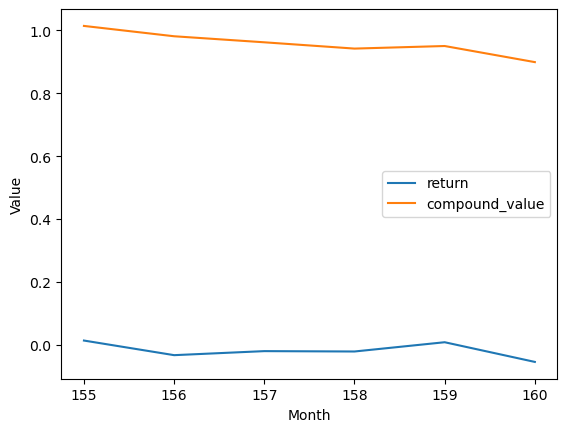

In [31]:
import matplotlib.pyplot as plt

# 绘制曲线图
plt.plot(portfolio_return_data['month'], portfolio_return_data['return'], label='return')
plt.plot(portfolio_return_data['month'], portfolio_return_data['compound_value'], label='compound_value')

# 添加图例和标签
plt.legend()
plt.xlabel('Month')
plt.ylabel('Value')

# 显示图像
plt.show()

In [39]:
return_data_combined
return_data_combined[return_data_combined['month'].isin(period_test)]['return']

0    0.014048
1   -0.032412
2   -0.019574
3   -0.020757
4    0.008688
5   -0.053893
Name: return, dtype: float64

In [40]:
# -- evaluation
ann_excess_return = np.mean(return_data_combined[return_data_combined['month'].isin(period_test)]['return']) * 12
ann_excess_vol = np.std(return_data_combined[return_data_combined['month'].isin(period_test)]['return']) * np.sqrt(12)
info_ratio = ann_excess_return / ann_excess_vol

print('annual excess return = %.2f' % ann_excess_return)
print('annual excess volatility = %.2f' % ann_excess_vol)
print('information ratio = %.2f' % info_ratio)

annual excess return = -0.21
annual excess volatility = 0.08
information ratio = -2.58


### 优化器_2

In [ ]:
import math

n = 20
k = 10

# 计算组合数
combinations = math.comb(n, k)

print("从100个数中选择10个数的可能性为:", combinations)